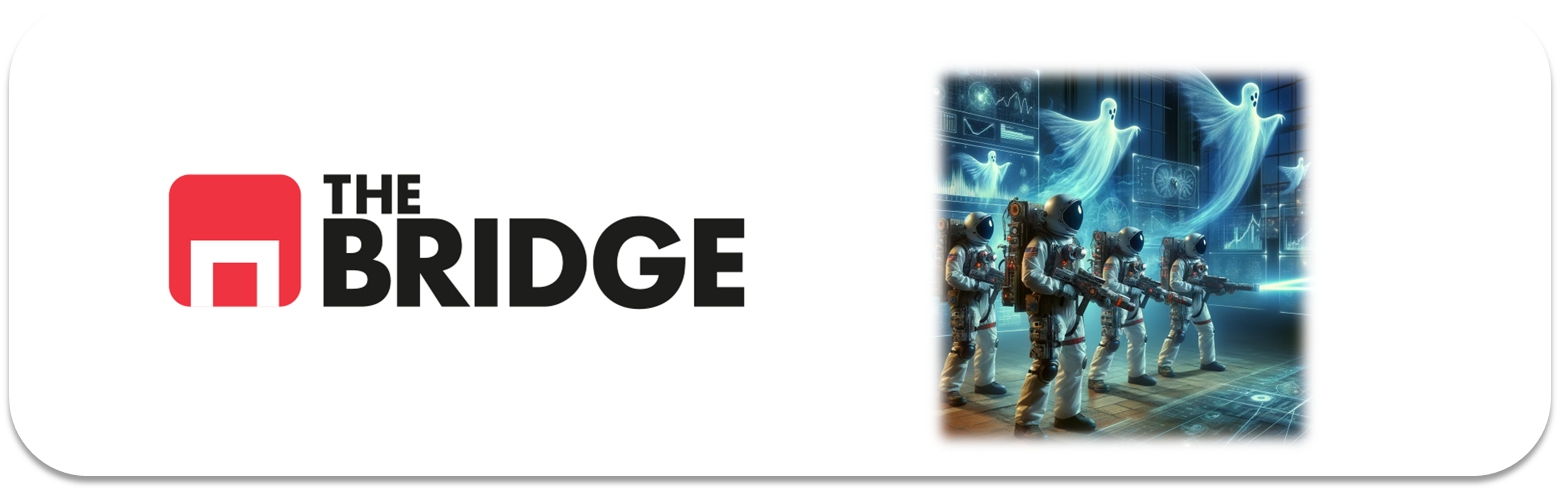

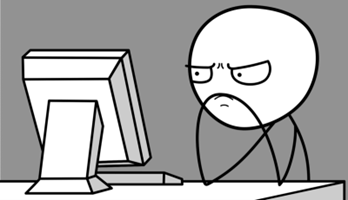

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [31]:
df = pd.read_csv('./data/AirPassengers.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [32]:
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

In [29]:
start = df.index.min()
end = df.index.max()
periodicity = pd.infer_freq(df.index)
print('Start:', start)
print('End:', end)
print('Periodicity:', periodicity)

Start: 1949-01-01 00:00:00
End: 1960-12-01 00:00:00
Periodicity: MS


### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

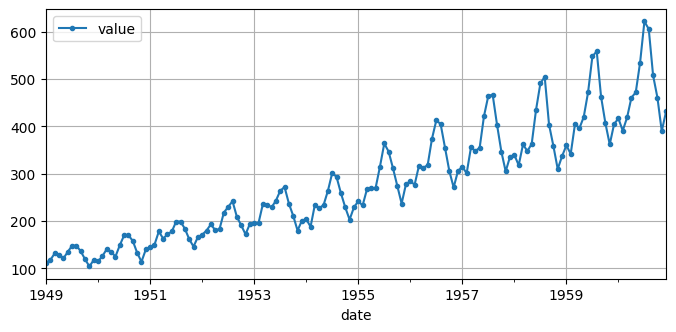

In [33]:
df[start:end].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Definitly has strong seasonality (and therefore low stationarity), with cyclical pattern repeating year after year:
- Yearly seasonality
- increase to peak in summer, then large decline until start of next year and then repeats

Definite clear upward trend:
- shows sustained growth year after year
- doesnt look linear

Fluctations seem to be increasing in time:
- more variation in passengers throughout a yearly cycle

Initial ideas:
- as there is both a clear trend and seeing strong seasonality thinking we probably need to use SARIMA here??

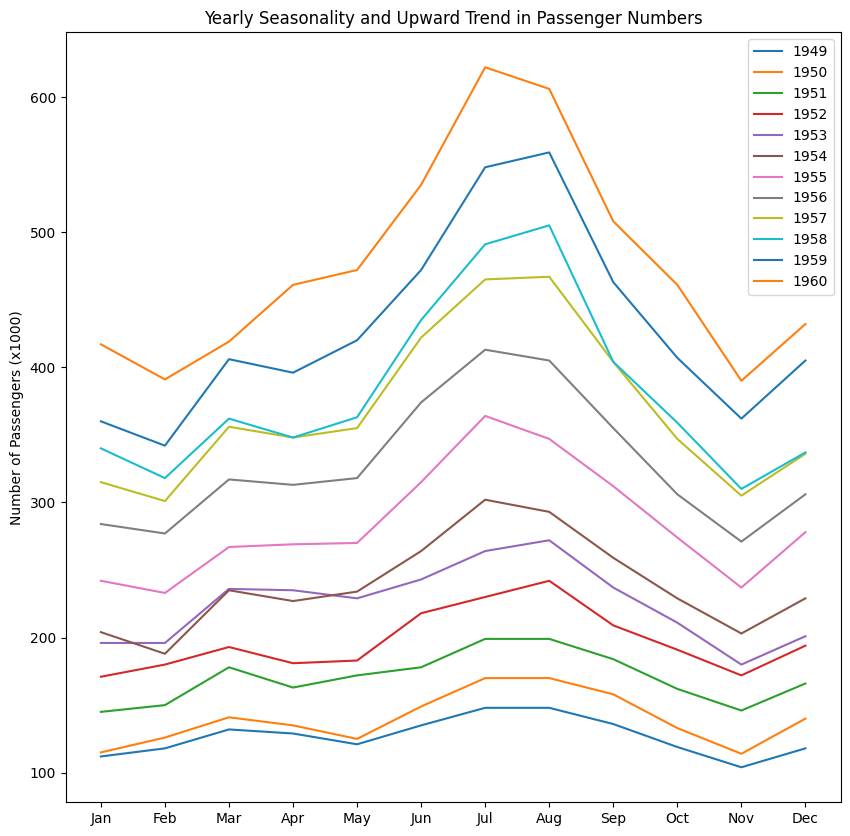

In [36]:
fig, axes = plt.subplots(1,1, figsize=(10,10), sharex=True)
for year in range(1949, 1961):
    axes.plot(df.loc[f'{year}']['value'].values, label = year)
plt.legend()
plt.ylabel('Number of Passengers (x1000)')
plt.xticks(ticks = range(0,12), labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Yearly Seasonality and Upward Trend in Passenger Numbers')
plt.show()

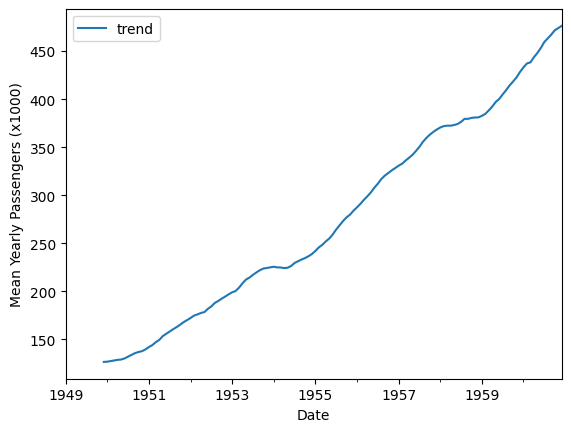

In [40]:
df.rolling(12).mean().rename(columns={'value':'trend'}).plot()
plt.xlabel('Date')
plt.ylabel('Mean Yearly Passengers (x1000)')
plt.show()

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

1. Method with adfuller

In [41]:
from statsmodels.tsa.stattools import adfuller

In [47]:
adfStat = adfuller(df['value'])[0]
pVal = adfuller(df['value'])[1]
criticalVals = adfuller(df['value'])[4]

print('ADF Stat:', adfStat)
print()
print('P Value:', pVal)
if pVal > 0.05:
    print(f'No evidence to reject the null hypothesis\nTime series is not stationary')
print()
print('Critical Values:', criticalVals)

ADF Stat: 0.8153688792060472

P Value: 0.991880243437641
No evidence to reject the null hypothesis
Time series is not stationary

Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


2. Mean and medians for different sections of the series

In [51]:
print(df['value'].iloc[:50].agg(['mean', 'median']))
print('-' * 40)
print(df['value'].iloc[50:100].agg(['mean', 'median']))
print('-' * 40)
print(df['value'].iloc[100:].agg(['mean', 'median']))

mean      159.88
median    160.00
Name: value, dtype: float64
----------------------------------------
mean      276.84
median    270.50
Name: value, dtype: float64
----------------------------------------
mean      421.068182
median    406.500000
Name: value, dtype: float64


- Significant change in mean and median with time
- For a series to have stationarity, by definition it should have a stable mean and variance for any given period of time

### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

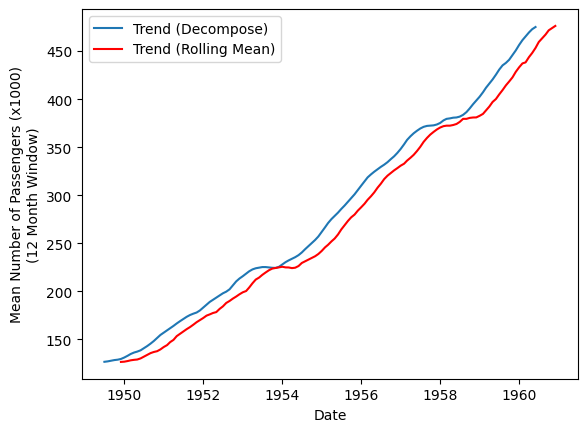

In [59]:
resultMulti = seasonal_decompose(df['value'], model='multiplicative', period=12)
plt.plot(resultMulti.trend, label='Trend (Decompose)')
plt.plot(df.rolling(12).mean().rename(columns={'value':'trend'}), color='red', label='Trend (Rolling Mean)')
plt.xlabel('Date')
plt.ylabel(f'Mean Number of Passengers (x1000)\n(12 Month Window)')
plt.legend()
plt.show()

### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

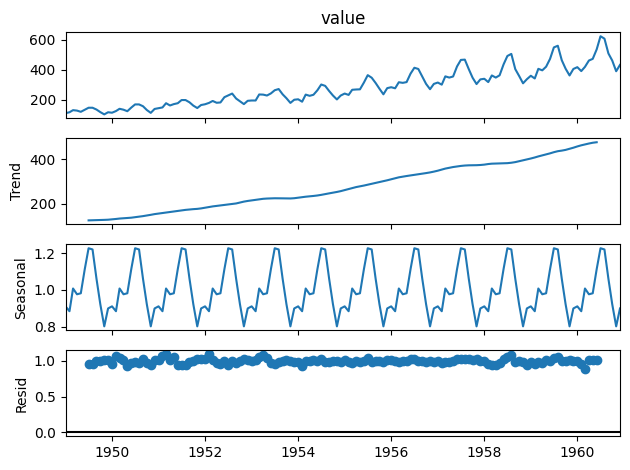

In [61]:
resultMulti.plot()
plt.show()

### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

In [62]:
dfAutocorr = df.copy()
for lag in range(1,25):
    dfAutocorr[f'lag{lag}'] = dfAutocorr['value'].shift(lag)

In [63]:
corrMatrix = dfAutocorr[['value']+[f'lag{lag}' for lag in range(1,25)]].corr()

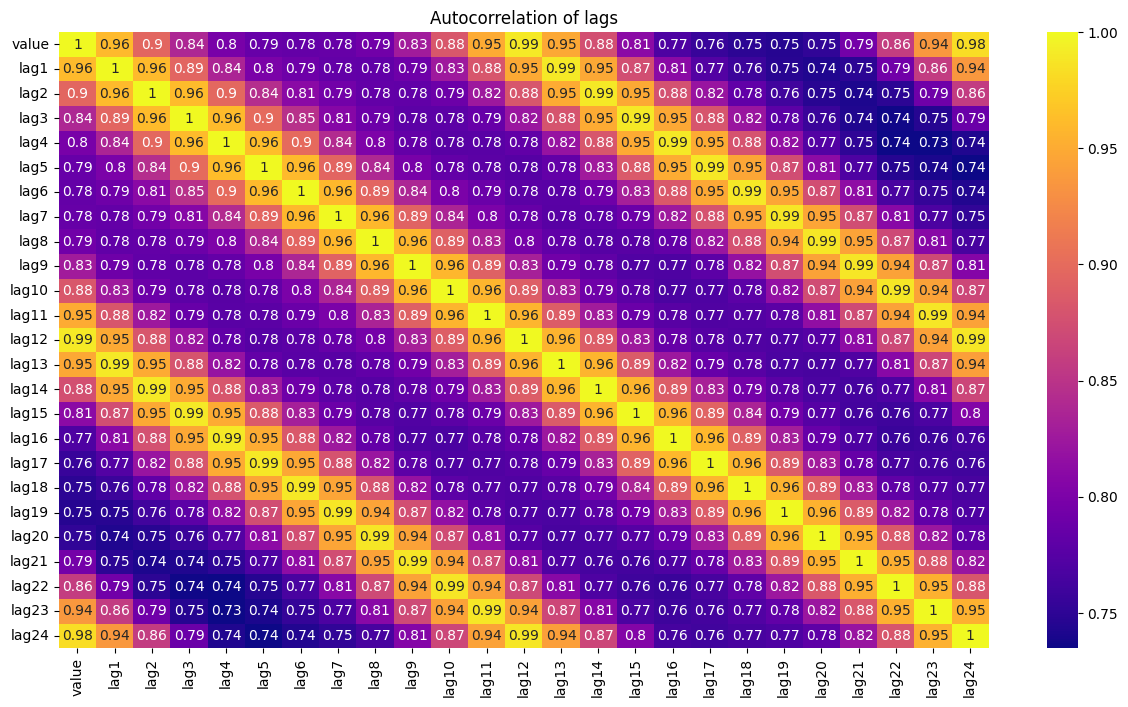

In [69]:
plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True, cmap='plasma')
plt.title('Autocorrelation of lags')
plt.show()

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

For every 12 instances. Each year

### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


In [71]:
train = df['value'].iloc[:124]
test = df['value'].iloc[124:]

### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

In [73]:
import itertools
from pmdarima.arima import ARIMA

In [77]:
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]
results = []
for param in pdq:
    try:
        modelARIMA = ARIMA(order=param)
        modelARIMA.fit(train)
        results.append((param, modelARIMA.aic()))
    except:
        continue

resultsDF = pd.DataFrame(results, columns=['ARIMA Params','AIC']).sort_values('AIC')
resultsDF.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

,ARIMA Params,AIC
83,"(3, 1, 3)",1119.169863
108,"(4, 1, 3)",1127.981808
114,"(4, 2, 4)",1128.170420
34,"(1, 1, 4)",1134.536073
107,"(4, 1, 2)",1134.574664


In [78]:
ARIMAModel = ARIMA(order = (3,1,3))
ARIMAModel.fit(train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

ARIMA(order=(3, 1, 3))

In [80]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

RMSE: 77.21633538861404
MAPE: 10.777933440136053%


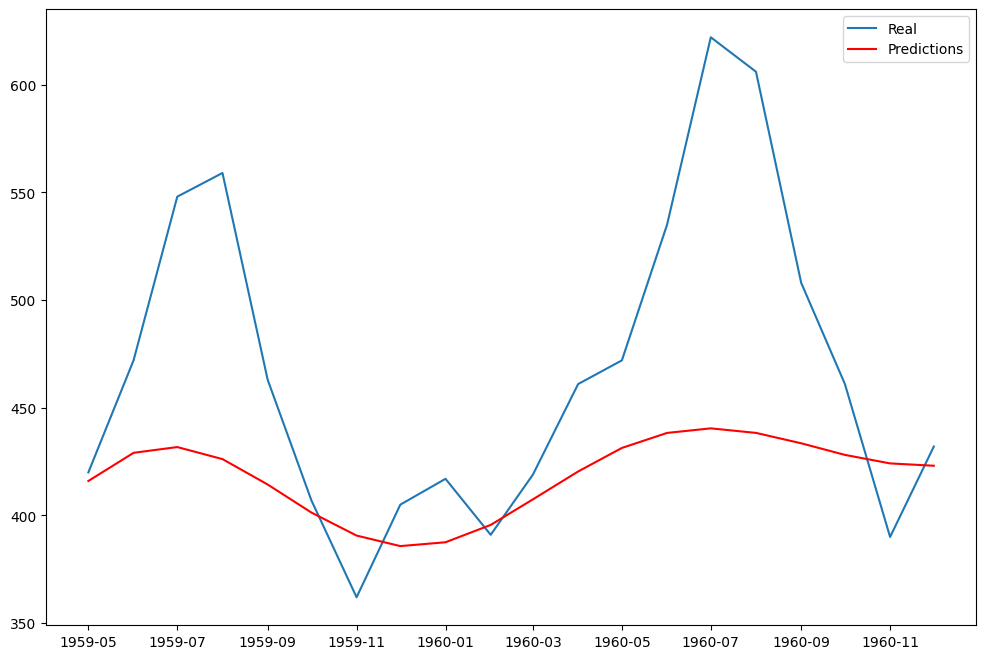

In [88]:
preds = ARIMAModel.predict(20)
rmse = root_mean_squared_error(test, preds)
mape = mean_absolute_percentage_error(test, preds)
print('RMSE:', rmse)
print(f'MAPE: {mape*100}%')

plt.figure(figsize=(12,8))
plt.plot(test, label='Real')
plt.plot(preds, color='red', label='Predictions')
plt.legend()
plt.show()

In [84]:
from pmdarima.arima import auto_arima

In [85]:
AutoARIMAModel = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_p=5,
                            max_q=5,
                            max_d=3,
                            trace=False)

RMSE: 113.15687712871207
MAPE: 17.15080425774798%


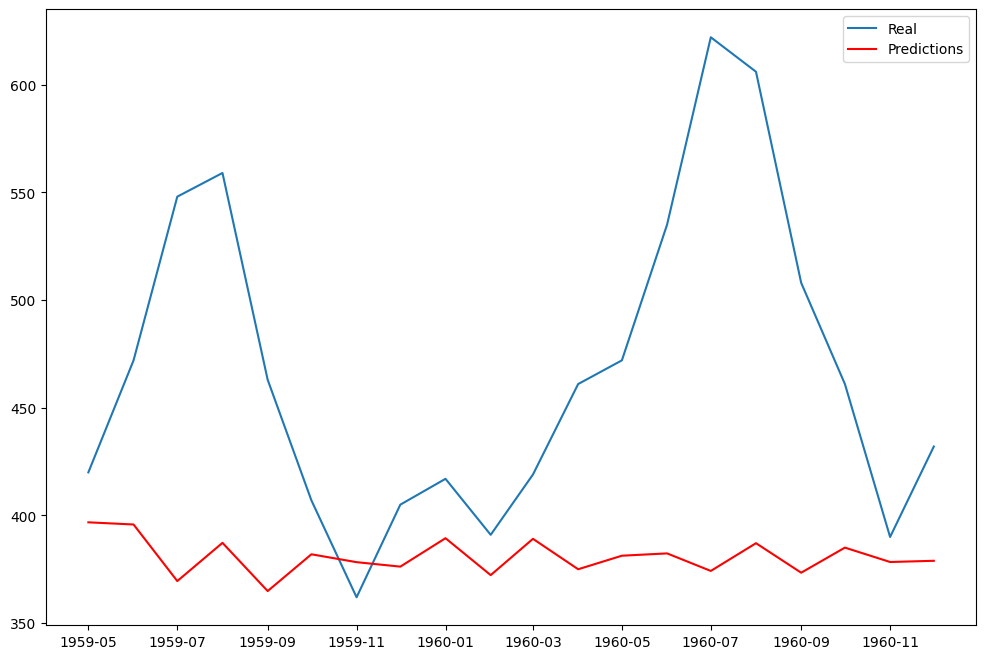

In [93]:
preds2 = AutoARIMAModel.predict(20)
rmse = root_mean_squared_error(test, preds2)
mape = mean_absolute_percentage_error(test, preds2)

print('RMSE:', rmse)
print(f'MAPE: {mape*100}%')

plt.figure(figsize=(12,8))
plt.plot(test, label='Real')
plt.plot(preds2, color='red', label='Predictions')
plt.legend()
plt.show()

### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

In [90]:
autoSARIMA = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=False)

RMSE: 30.673685879922207
MAPE: 5.860023561656837%


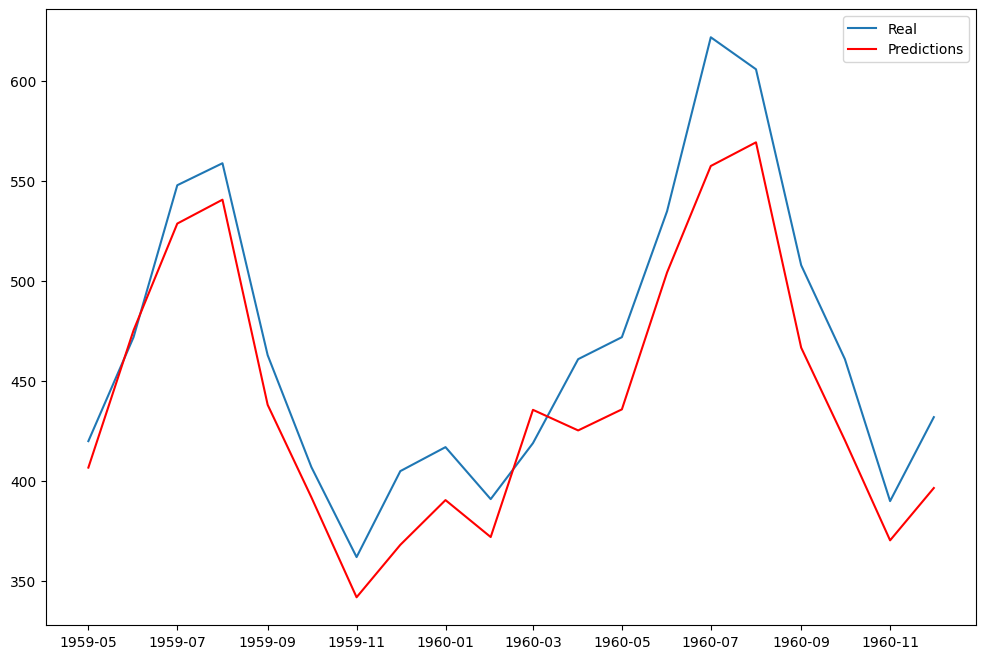

In [92]:
preds3 = autoSARIMA.predict(20)
rmse = root_mean_squared_error(test, preds3)
mape = mean_absolute_percentage_error(test, preds3)

print('RMSE:', rmse)
print(f'MAPE: {mape*100}%')

plt.figure(figsize=(12,8))
plt.plot(test, label='Real')
plt.plot(preds3, color='red', label='Predictions')
plt.legend()
plt.show()